In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)


In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [3]:
#Train data
df_train=pd.read_csv('train.csv')

df_train.head()
#Test data
df_test=pd.read_csv('test.csv')

df_test.head()
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

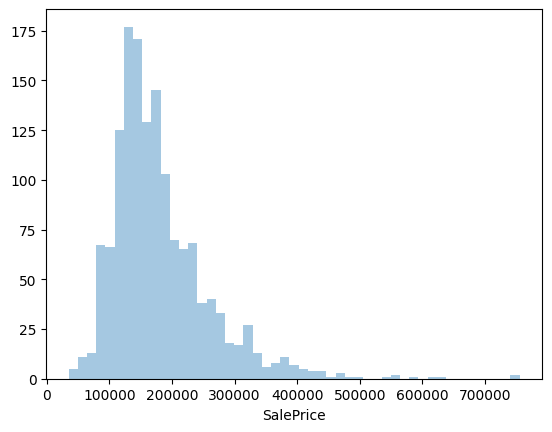

In [4]:
#distribution of values in target feature
sns.distplot(df_train.get("SalePrice"), kde=False)
plt.show()

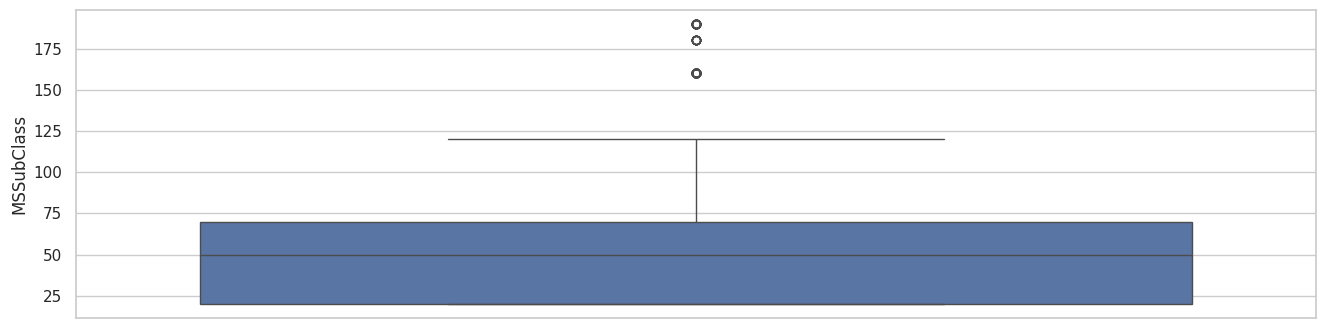

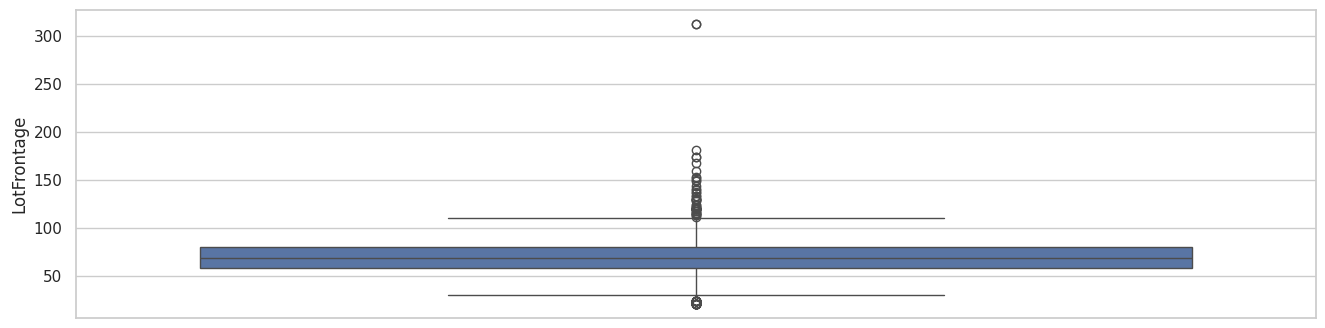

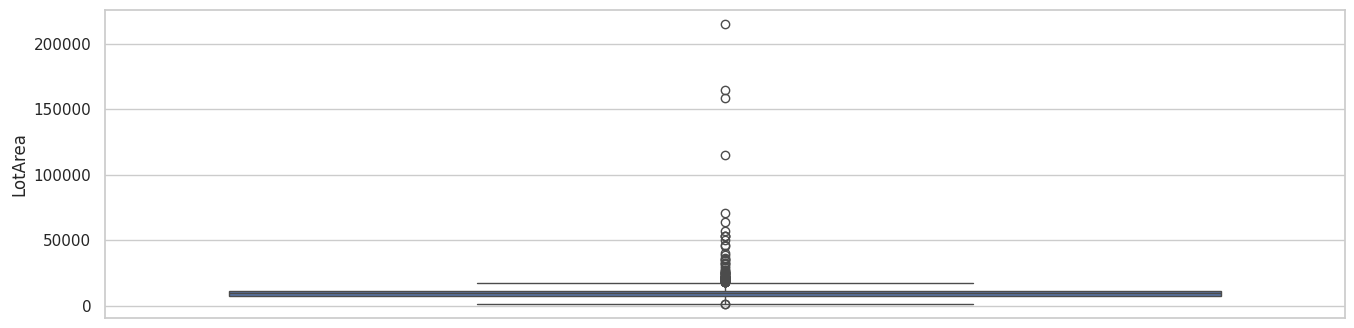

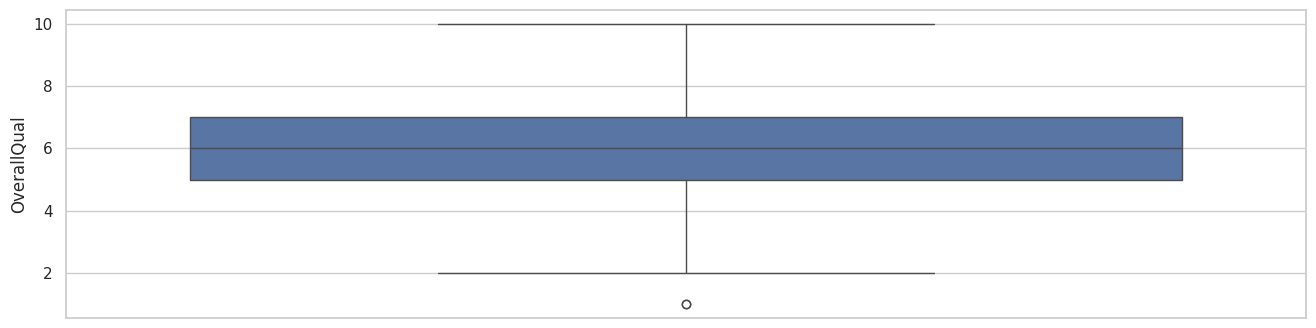

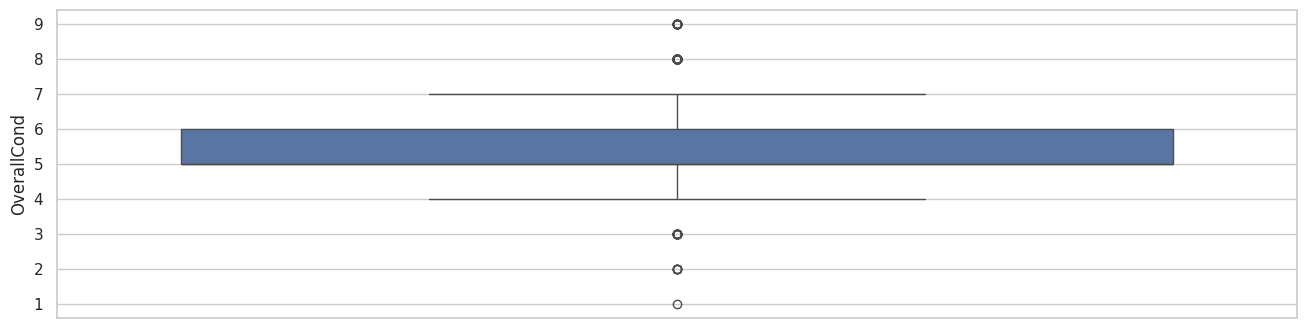

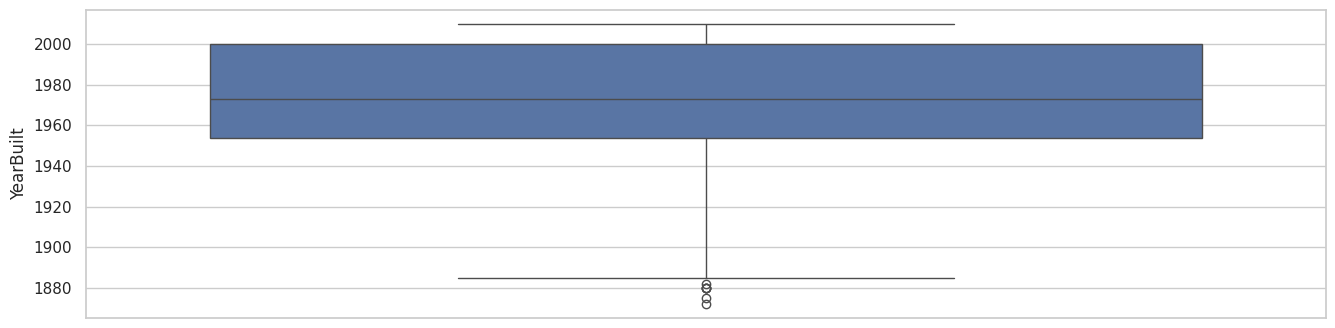

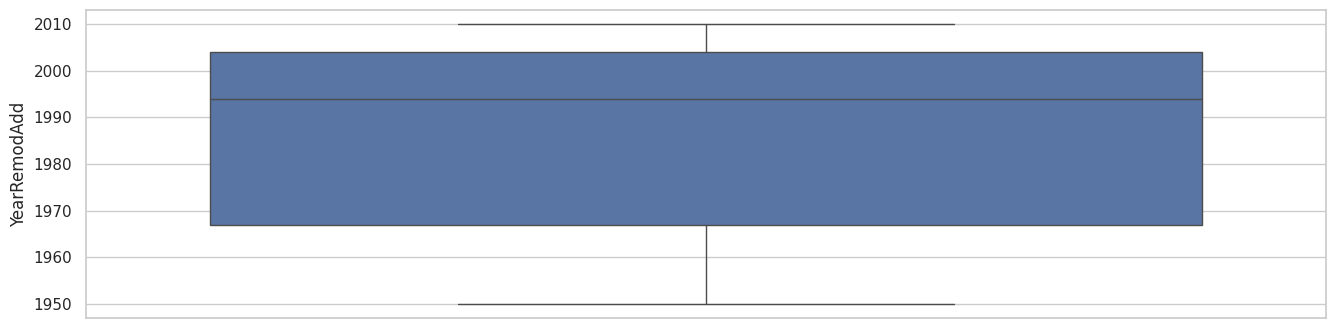

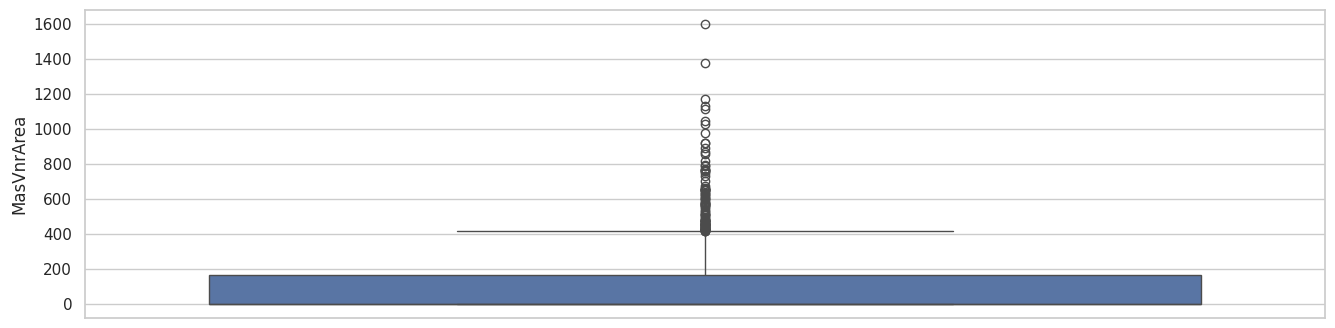

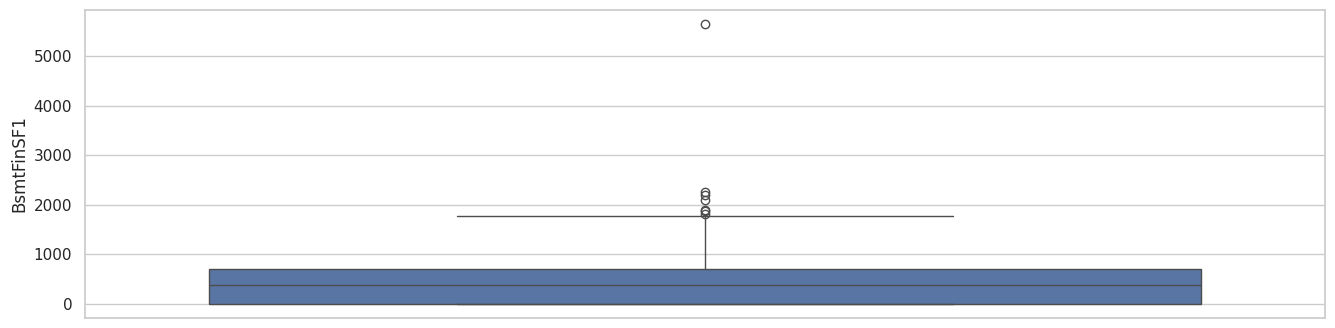

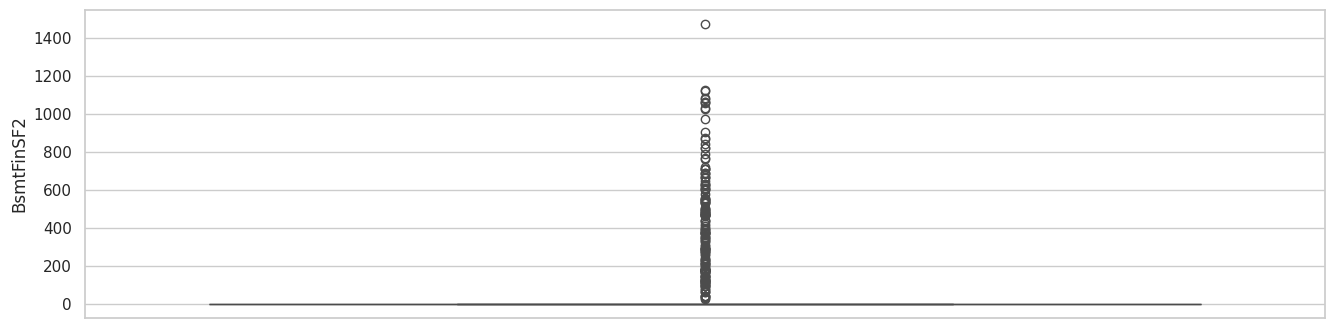

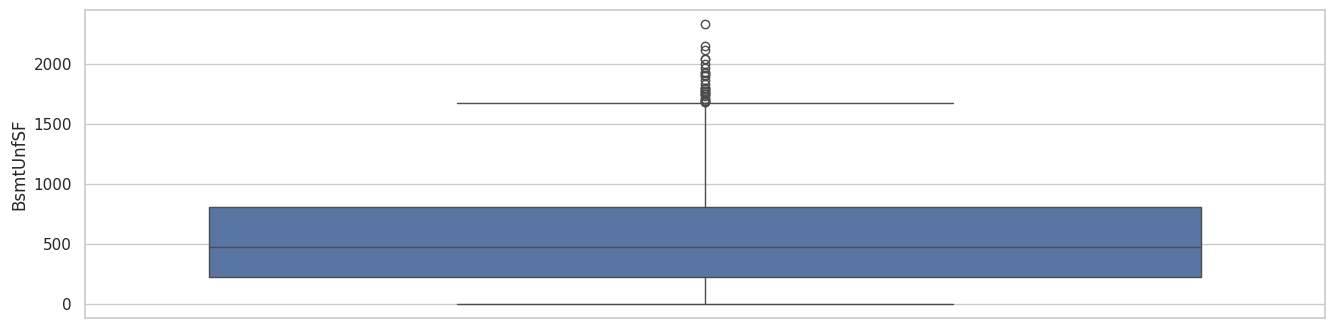

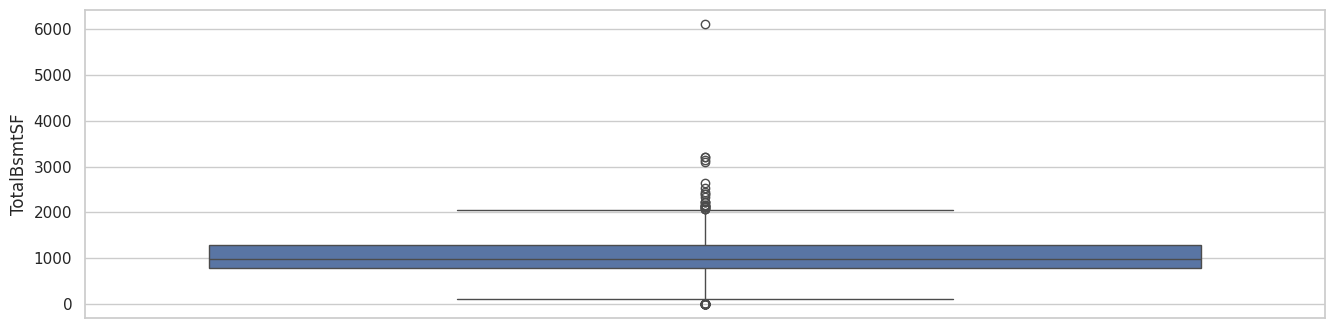

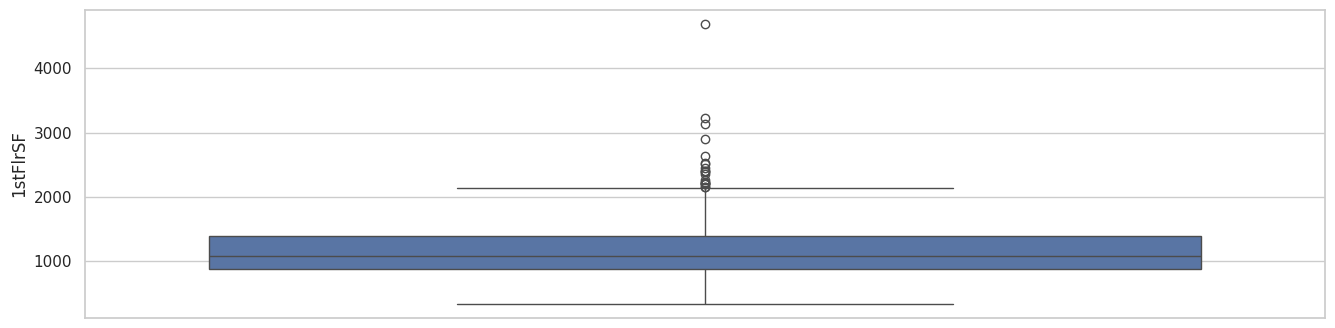

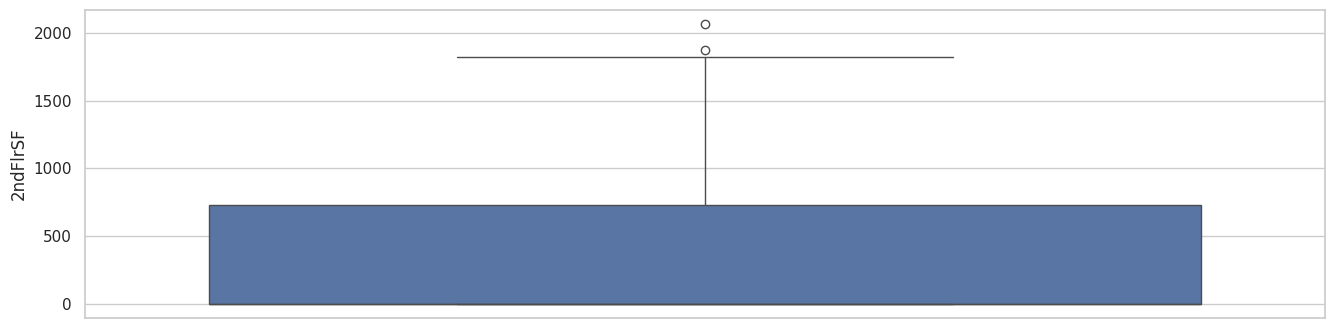

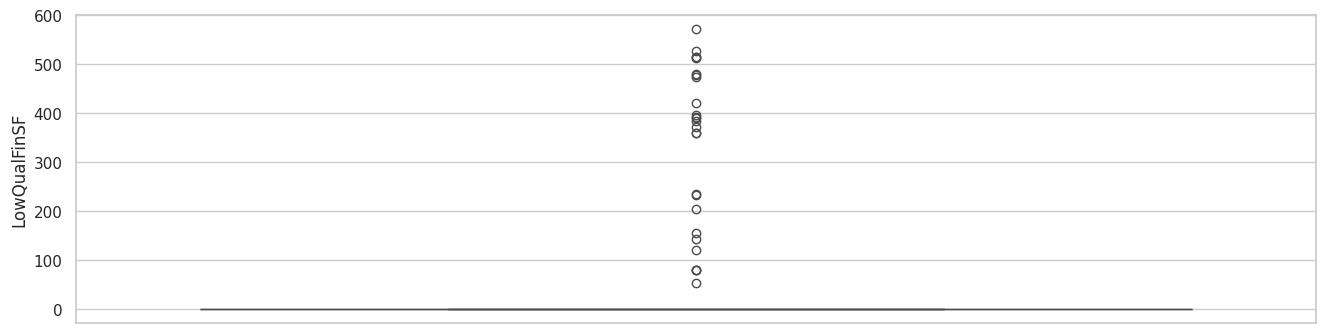

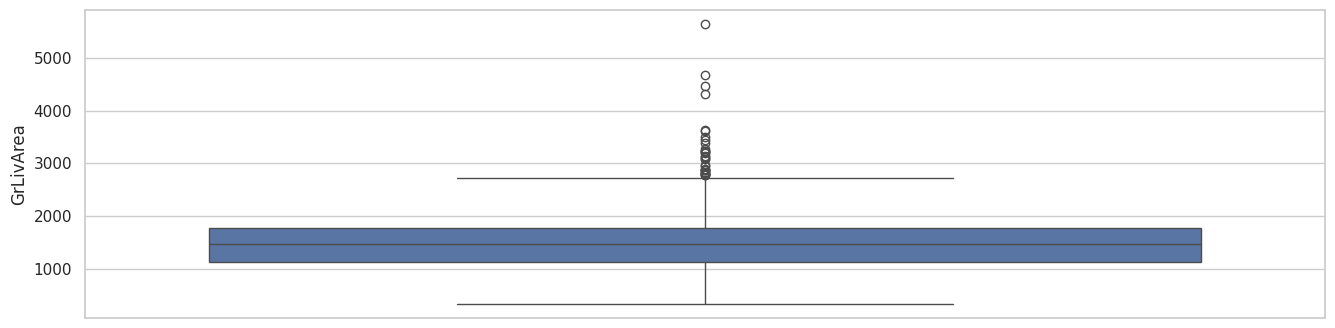

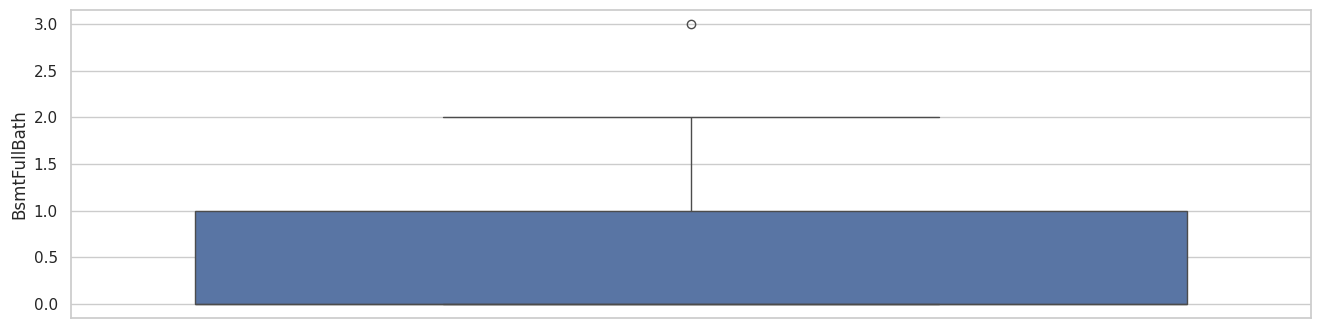

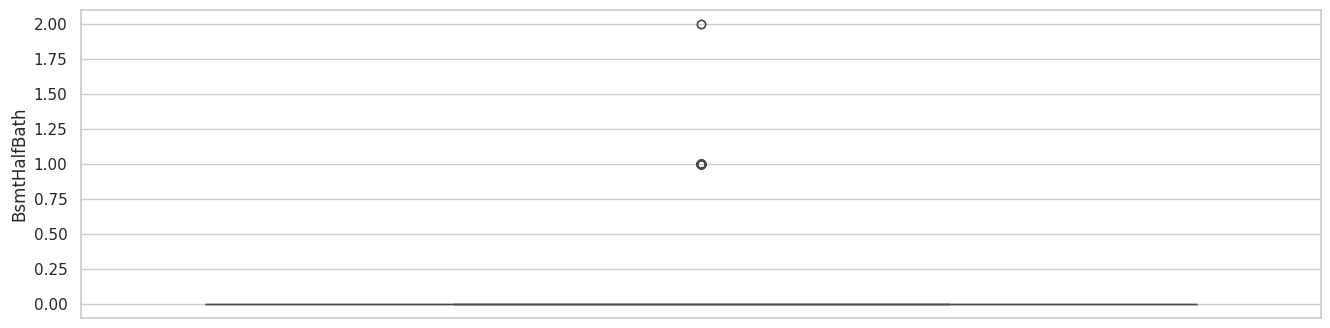

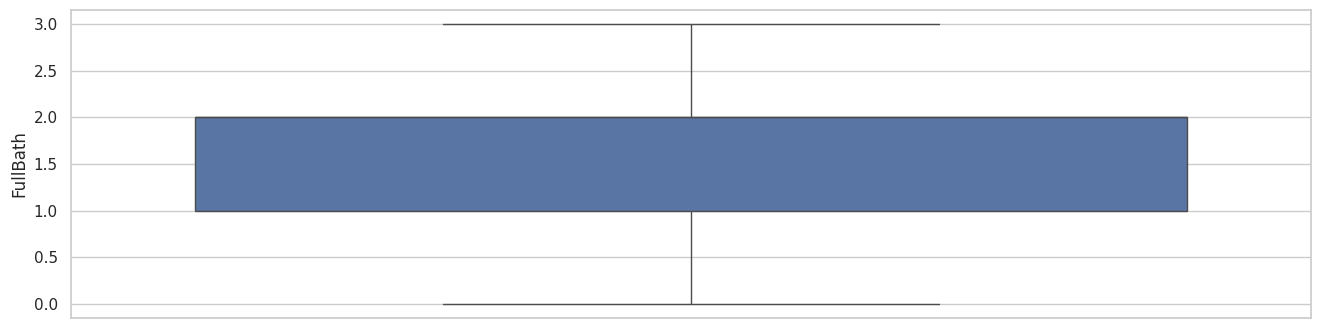

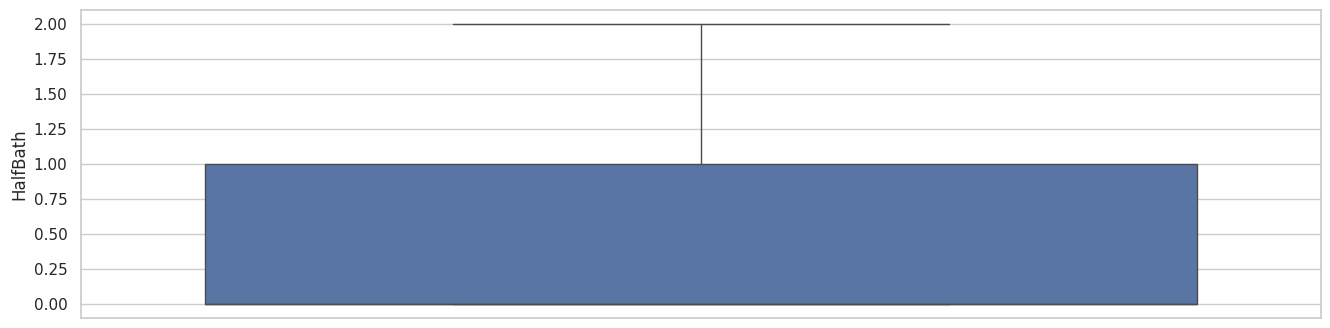

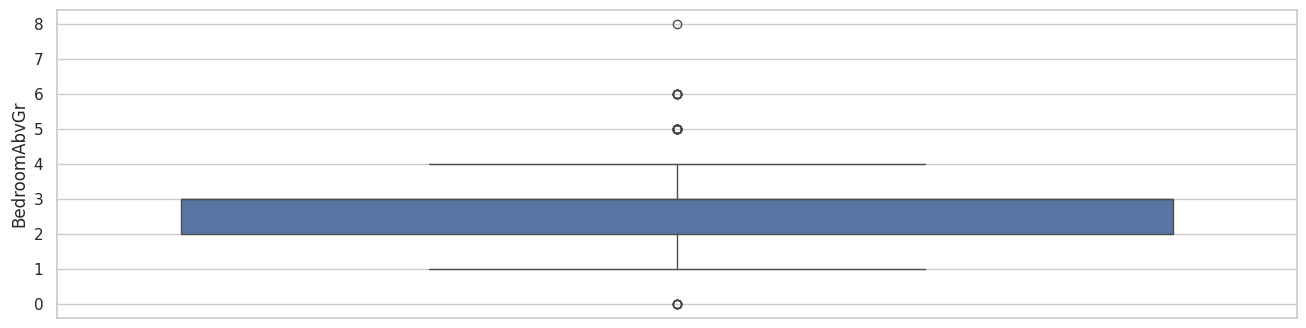

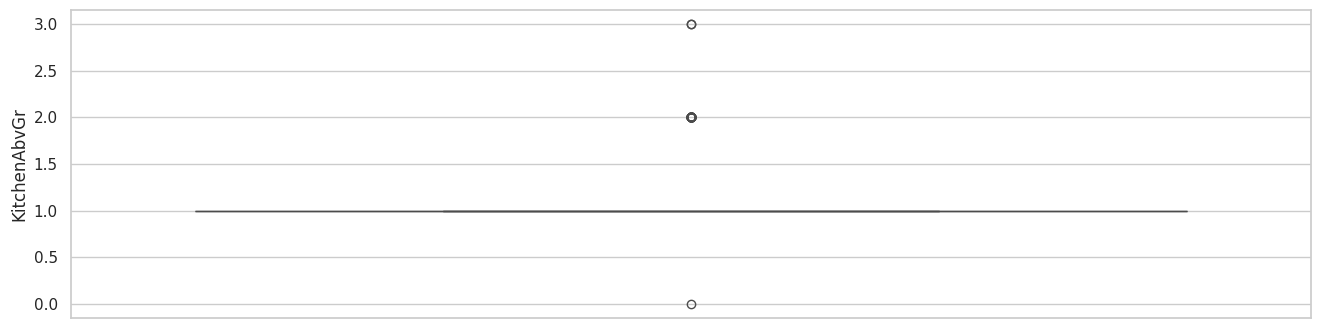

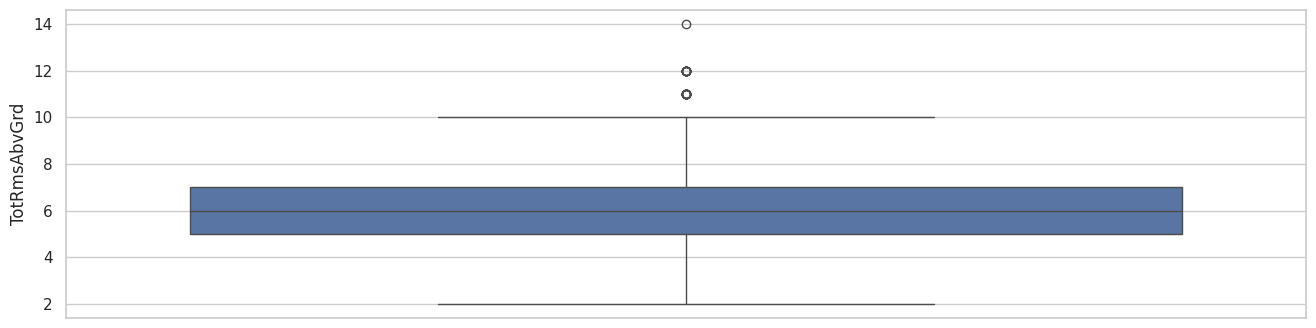

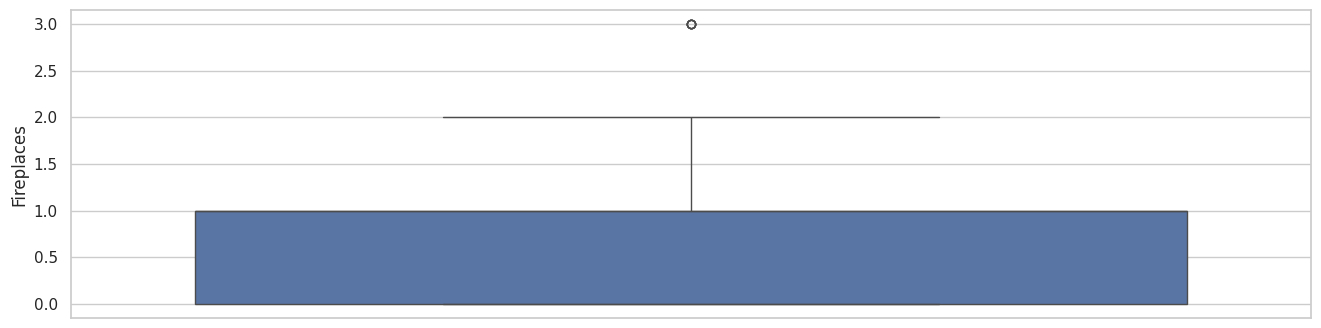

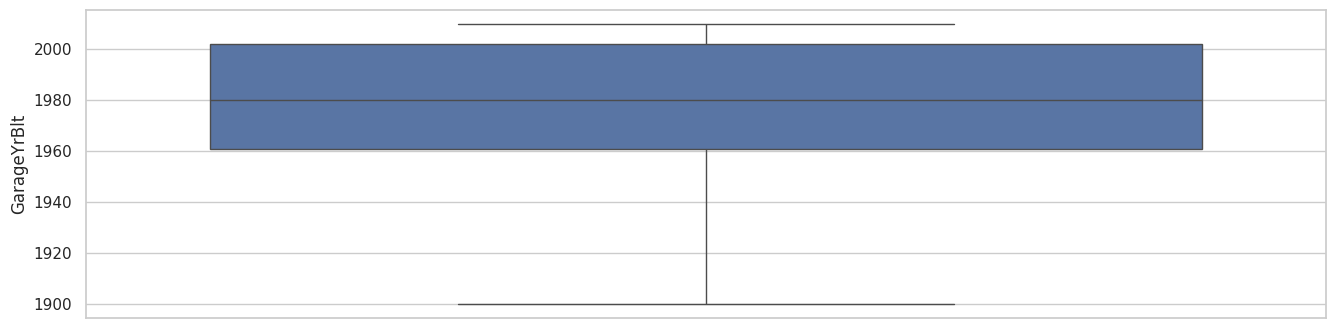

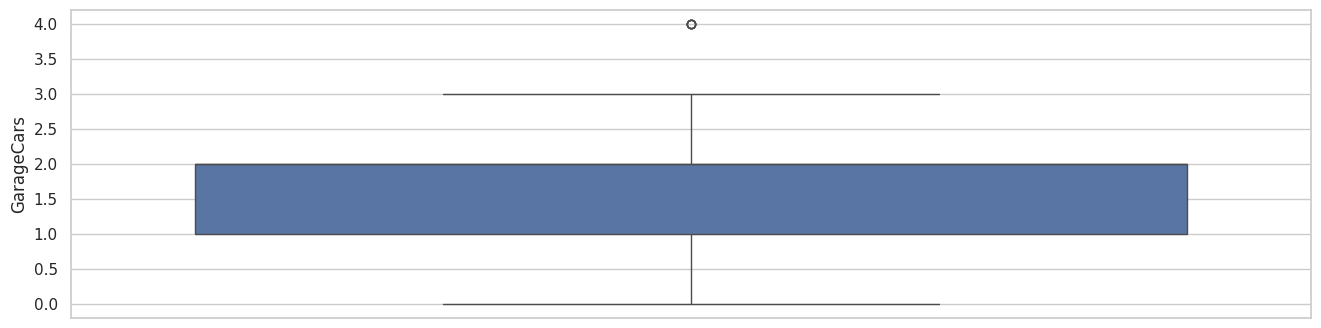

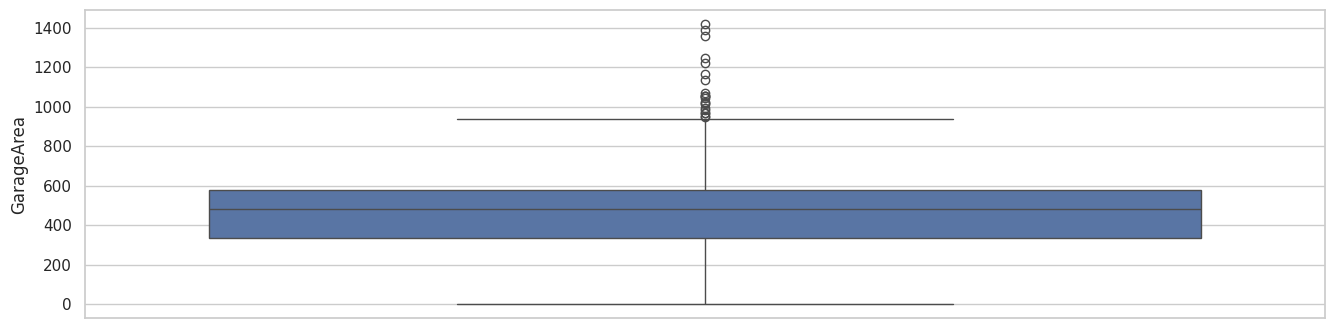

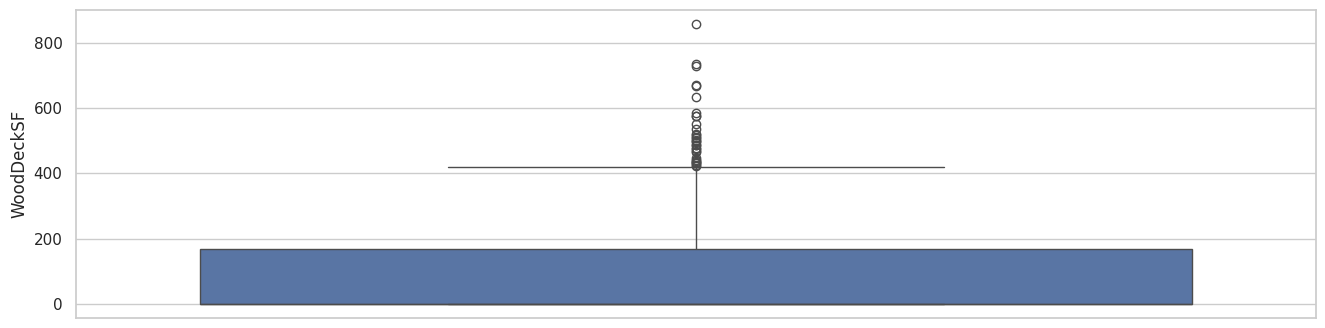

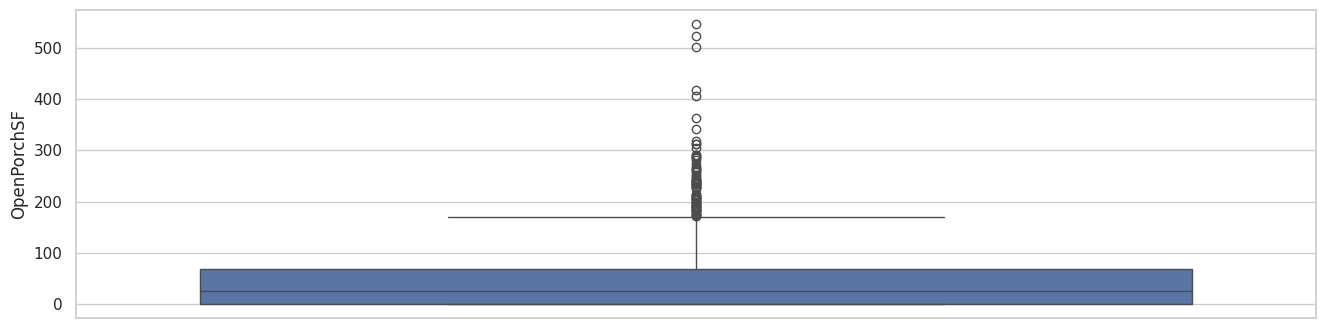

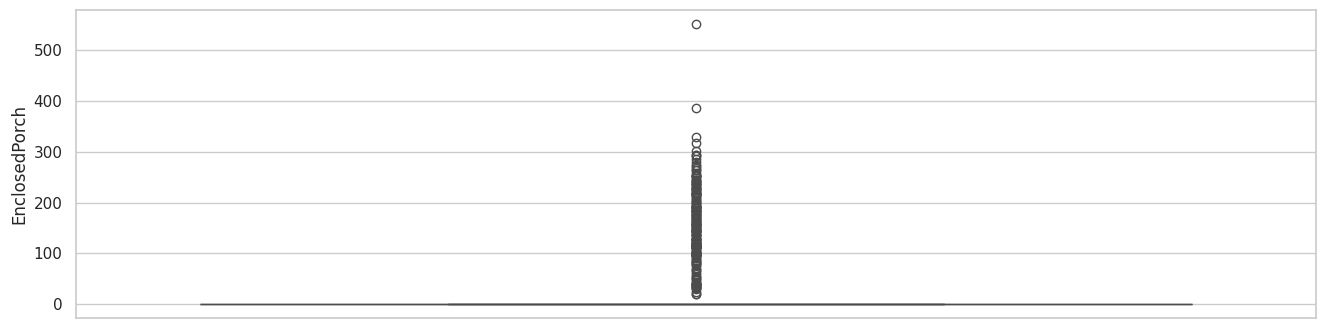

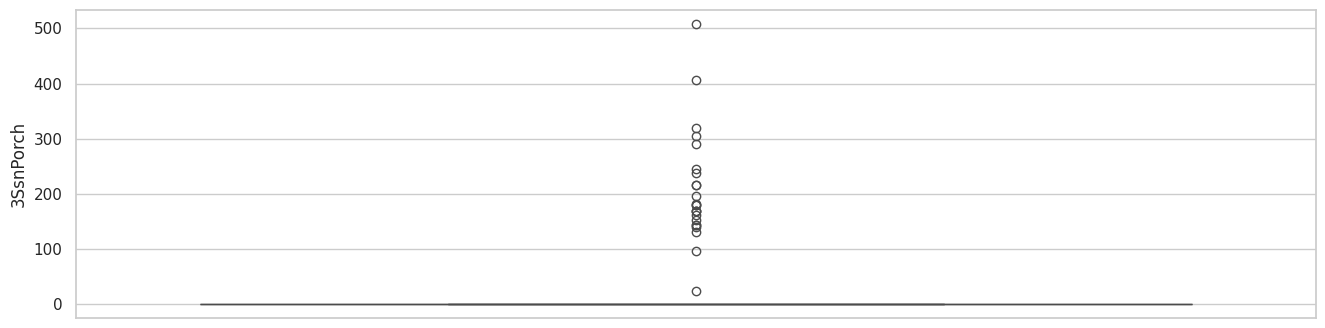

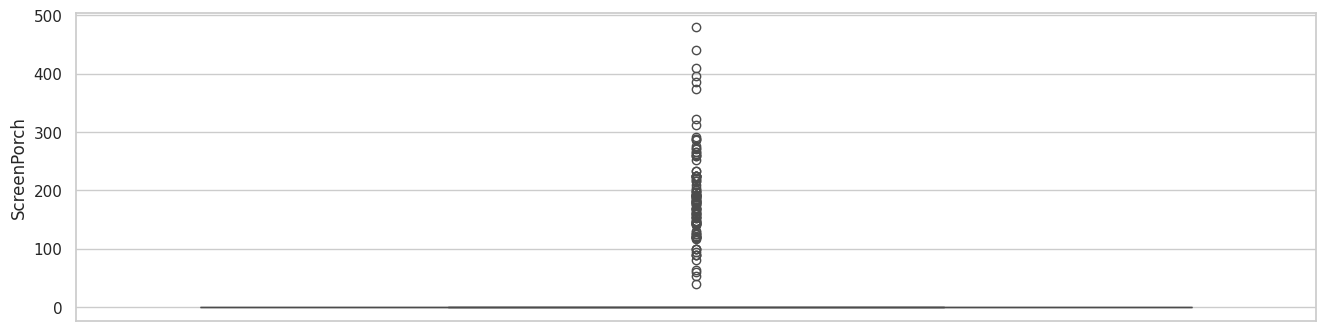

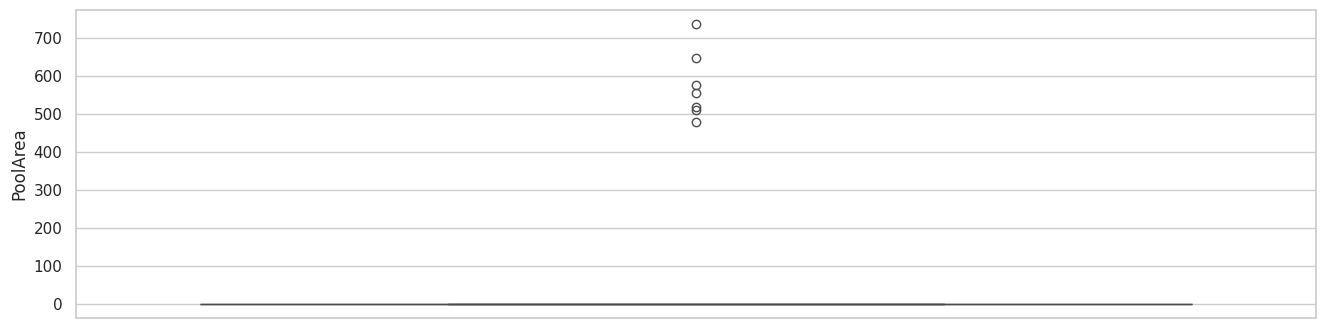

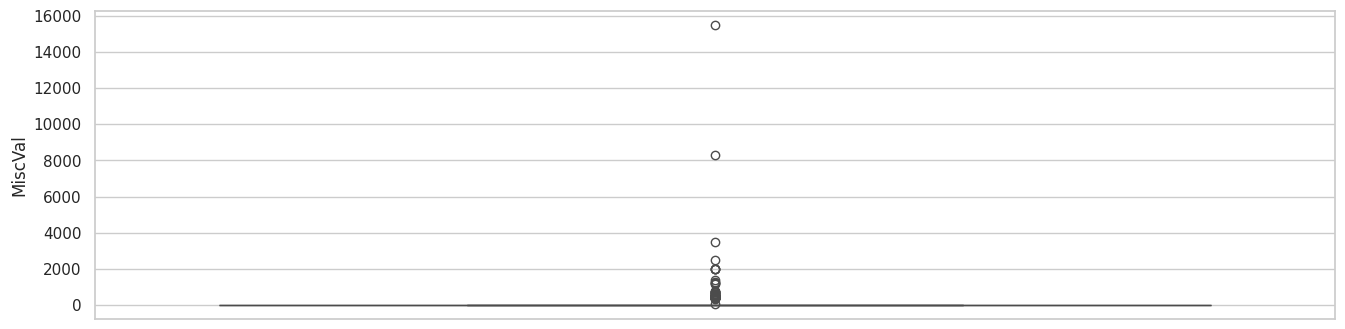

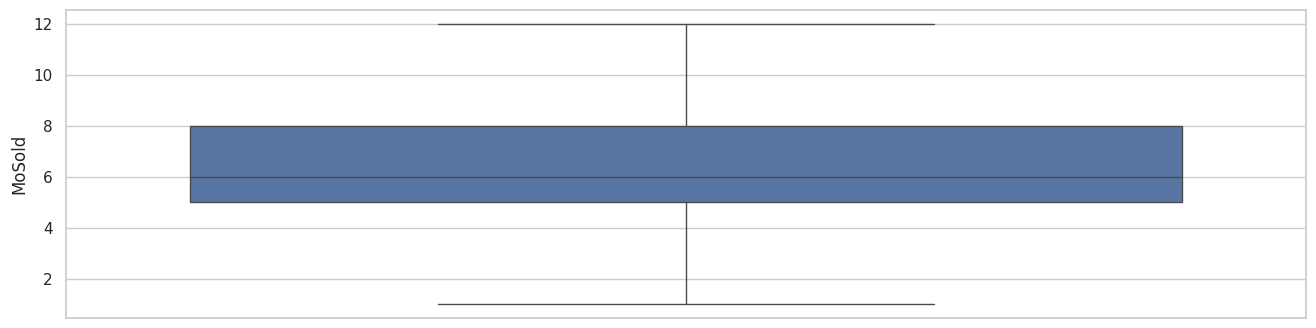

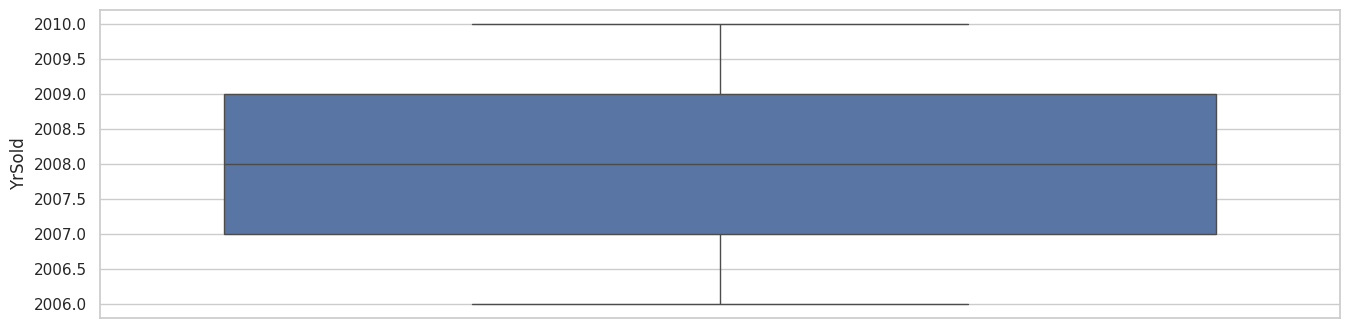

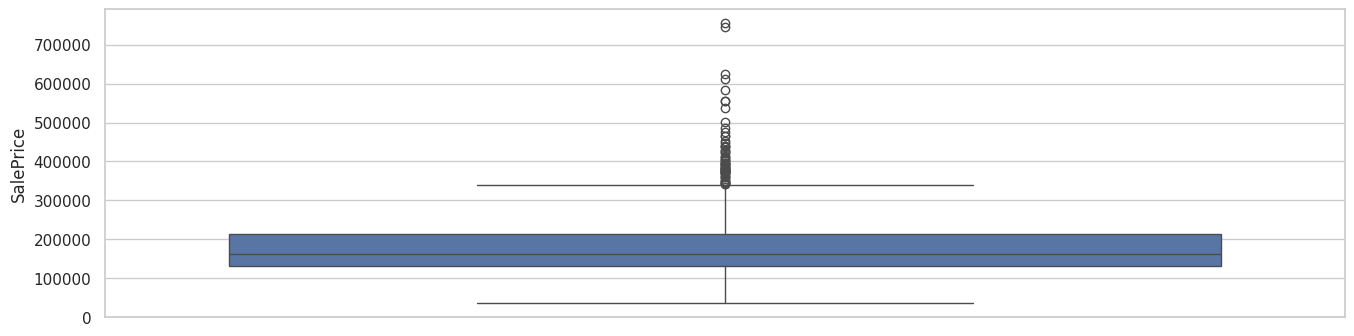

In [5]:
# find outliers for all the numerical dataset (before handling missing values)

numerical_df = df_train.select_dtypes(exclude=['object'])
numerical_df = numerical_df.drop(["Id"], axis=1)

for column in numerical_df:
    plt.figure(figsize=(16, 4))
    sns.set_theme(style="whitegrid")
    sns.boxplot(numerical_df[column])

In [6]:
#features present in train data that are not present in test data
feature_train_not_test = [col for col in df_train.columns if col not in df_test.columns and col != 'SalePrice']

print(feature_train_not_test)

[]


In [7]:
#features present in test data that are not present in train data

feature_test_not_train = [col for col in df_test.columns if col not in df_train.columns]

print(feature_test_not_train)

[]


In [8]:
#combine train and test data for data preprocessing

df_merge=pd.concat([df_test.assign(ind="test"), df_train.assign(ind="train")])

df_merge.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,test,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,test,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,test,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,test,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,test,NaN


In [9]:
#Function to get count of missing values in each column

def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]
print(get_cols_with_missing_values(df_merge))

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64


In [10]:
#Get a list of all the categorical features that have the keyword 'Qual' OR 'Cond' OR 'Qu' OR 'QC' in the feature name
feature_rating_Qual = [col for col in df_merge.columns if 'Qual' in col and df_merge[col].dtypes=='object']
feature_rating_Cond = [col for col in df_merge.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df_merge[col].dtypes=='object']
feature_rating_Qu = [col for col in df_merge.columns if 'Qu' in col and df_merge[col].dtypes=='object' and col not in feature_rating_Qual]
feature_rating_QC = [col for col in df_merge.columns if 'QC' in col and df_merge[col].dtypes=='object']

cat_feature_with_rating = feature_rating_Qual + feature_rating_Cond + feature_rating_Qu + feature_rating_QC
for x in cat_feature_with_rating:
    print(x)

ExterQual
BsmtQual
KitchenQual
GarageQual
ExterCond
BsmtCond
GarageCond
FireplaceQu
HeatingQC
PoolQC


In [12]:
#Categorical features who have NA as a correct value

cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
df_merge[cat_feature_with_legit_na].head()

,Alley,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageFinish,Fence,MiscFeature
0,NaN,No,Rec,LwQ,Attchd,Unf,MnPrv,NaN
1,NaN,No,ALQ,Unf,Attchd,Unf,NaN,Gar2
2,NaN,No,GLQ,Unf,Attchd,Fin,MnPrv,NaN
3,NaN,No,GLQ,Unf,Attchd,Fin,NaN,NaN
4,NaN,No,ALQ,Unf,Attchd,RFn,NaN,NaN


In [13]:
ordinal_cat_features = cat_feature_with_rating + cat_feature_with_legit_na
df_merge[ordinal_cat_features].head()

,ExterQual,BsmtQual,KitchenQual,GarageQual,ExterCond,BsmtCond,GarageCond,FireplaceQu,HeatingQC,PoolQC,Alley,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageFinish,Fence,MiscFeature
0,TA,TA,TA,TA,TA,TA,TA,NaN,TA,NaN,NaN,No,Rec,LwQ,Attchd,Unf,MnPrv,NaN
1,TA,TA,Gd,TA,TA,TA,TA,NaN,TA,NaN,NaN,No,ALQ,Unf,Attchd,Unf,NaN,Gar2
2,TA,Gd,TA,TA,TA,TA,TA,TA,Gd,NaN,NaN,No,GLQ,Unf,Attchd,Fin,MnPrv,NaN
3,TA,TA,Gd,TA,TA,TA,TA,Gd,Ex,NaN,NaN,No,GLQ,Unf,Attchd,Fin,NaN,NaN
4,Gd,Gd,Gd,TA,TA,TA,TA,NaN,Ex,NaN,NaN,No,ALQ,Unf,Attchd,RFn,NaN,NaN


In [14]:
#On checking the data description, Missing is valid in some categorical

df_merge[ordinal_cat_features] = df_merge[ordinal_cat_features].fillna("Missing")
print(get_cols_with_missing_values(df_merge[ordinal_cat_features]))

Series([], dtype: int64)


In [15]:
categorical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes=='object' and cname!='ind']
remaining_cat_cols = [cname for cname in categorical_cols if cname not in ordinal_cat_features]
#Handling Missing Values in Categorical features by replacing them with the feature mode value
print(df_merge.info())
for col in remaining_cat_cols:
     df_merge[col] = df_merge[col].fillna(df_merge[col].mode()[0])

df_merge['MSSubClass'] = df_merge['MSSubClass'].astype('object')
print(df_merge.info())
categorical_cols=['MSSubClass']+categorical_cols
remaining_cat_cols=['MSSubClass']+remaining_cat_cols
print(categorical_cols)
print(df_merge.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

In [ ]:
print(df_merge.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

In [16]:
#Select categorical columns with low cardinality
categorical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes=='object' and df_merge[cname].nunique()<20]
numerical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes!='object']

my_cols = numerical_cols + categorical_cols

df_merge_clean = df_merge[my_cols].copy()

In [18]:
#Handling Missing Values in Numerical features by replacing them with Mean value
df_merge[numerical_cols]=df_merge[numerical_cols].fillna(df_merge[numerical_cols].mean())

In [19]:
print(len(numerical_cols))
print(len(categorical_cols))

37
44


In [20]:
#Drop 'Id' feature
df_merge_clean.drop('Id', axis=1, inplace=True)

In [21]:
df_merge_clean['GarageYrBlt'] = df_merge_clean['YrSold'] - df_merge_clean['GarageYrBlt']
df_merge_clean['YearBuilt'] = df_merge_clean['YrSold'] - df_merge_clean['YearBuilt']
df_merge_clean['YearRemodAdd'] = df_merge_clean['YrSold'] - df_merge_clean['YearRemodAdd']
df_merge_clean.drop(["YrSold"], axis=1, inplace=True)
df_merge_clean.drop(["MoSold"], axis=1, inplace=True)

In [22]:
#TotalBsmtSF(Total square feet of basement area) = BsmtFinSF1(Type 1 finished square feet) + BsmtFinSF2(Type 2 finished square feet) + BsmtUnfSF(Unfinished square feet of basement area)
df_merge_clean.drop(["TotalBsmtSF"], axis=1, inplace=True)

df_merge_clean['BsmtFinSF'] = df_merge_clean['BsmtFinSF1'] + df_merge_clean['BsmtFinSF2']
df_merge_clean.drop(["BsmtFinSF1"], axis=1, inplace=True)
df_merge_clean.drop(["BsmtFinSF2"], axis=1, inplace=True)

#Total floor square feet
df_merge_clean['TotalFlrSF'] = df_merge_clean['1stFlrSF'] + df_merge_clean['2ndFlrSF']

df_merge_clean.drop(["1stFlrSF"], axis=1, inplace=True)
df_merge_clean.drop(["2ndFlrSF"], axis=1, inplace=True)

In [23]:
df_merge_clean['Total_Bath'] = (df_merge_clean['FullBath']
        + (0.5*df_merge_clean['HalfBath'])
        + df_merge_clean['BsmtFullBath']
        + (0.5*df_merge_clean['BsmtHalfBath']))

df_merge_clean.drop(["FullBath"], axis=1, inplace=True)
df_merge_clean.drop(["HalfBath"], axis=1, inplace=True)
df_merge_clean.drop(["BsmtFullBath"], axis=1, inplace=True)
df_merge_clean.drop(["BsmtHalfBath"], axis=1, inplace=True)

In [24]:
numerical_cols = [cname for cname in df_merge_clean.columns if df_merge_clean[cname].dtypes!='object' and cname!='SalePrice']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_merge_clean[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,NaN,NaN,False
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,0.598609,0.598609,True
5,YearRemodAdd,0.450226,0.450226,False
6,MasVnrArea,NaN,NaN,False
7,BsmtUnfSF,NaN,NaN,False
8,LowQualFinSF,12.088761,12.088761,True
9,GrLivArea,1.269358,1.269358,True


In [25]:
df_merge_clean[numerical_cols].describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinSF,TotalFlrSF,Total_Bath
count,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2919.000000,2917.000000
mean,69.305795,10168.114080,6.089072,5.564577,36.479959,23.528263,102.201312,560.772104,4.694416,1500.759849,2.860226,1.044536,6.451524,0.597122,29.676087,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,491.005483,1496.065433,2.218375
std,23.344905,7886.996359,1.409947,1.113131,30.336182,20.892061,179.334253,439.543659,46.396825,506.051045,0.822693,0.214462,1.569379,0.646129,25.613957,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,477.205053,503.675790,0.808455
min,21.000000,1300.000000,1.000000,1.000000,-1.000000,-2.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,7478.000000,5.000000,5.000000,7.000000,4.000000,0.000000,220.000000,0.000000,1126.000000,2.000000,1.000000,5.000000,0.000000,6.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1120.000000,1.500000
50%,68.000000,9453.000000,6.000000,5.000000,35.000000,15.000000,0.000000,467.000000,0.000000,1444.000000,3.000000,1.000000,6.000000,1.000000,29.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,457.500000,1440.000000,2.000000
75%,80.000000,11570.000000,7.000000,6.000000,54.500000,43.000000,164.000000,805.500000,0.000000,1743.500000,3.000000,1.000000,7.000000,1.000000,48.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,805.750000,1742.500000,2.500000
max,313.000000,215245.000000,10.000000,9.000000,136.000000,60.000000,1600.000000,2336.000000,1064.000000,5642.000000,8.000000,3.000000,15.000000,4.000000,114.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,5644.000000,5642.000000,7.000000


In [26]:
#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_merge_clean[column] = np.log1p(df_merge_clean[column])

In [27]:
#Before encoding - features with rating
df_merge_clean[cat_feature_with_rating]

,ExterQual,BsmtQual,KitchenQual,GarageQual,ExterCond,BsmtCond,GarageCond,FireplaceQu,HeatingQC,PoolQC
0,TA,TA,TA,TA,TA,TA,TA,Missing,TA,Missing
1,TA,TA,Gd,TA,TA,TA,TA,Missing,TA,Missing
2,TA,Gd,TA,TA,TA,TA,TA,TA,Gd,Missing
3,TA,TA,Gd,TA,TA,TA,TA,Gd,Ex,Missing
4,Gd,Gd,Gd,TA,TA,TA,TA,Missing,Ex,Missing
...,...,...,...,...,...,...,...,...,...,...
1455,TA,Gd,TA,TA,TA,TA,TA,TA,Ex,Missing
1456,TA,Gd,TA,TA,TA,TA,TA,TA,TA,Missing
1457,Ex,TA,Gd,TA,Gd,Gd,TA,Gd,Ex,Missing
1458,TA,TA,Gd,TA,TA,TA,TA,Missing,Gd,Missing


In [28]:
for col in cat_feature_with_rating:
    if 'Missing' in df_merge_clean[col].value_counts().index:
        df_merge_clean[col] = df_merge_clean[col].map({"Missing":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5})
    else:
        df_merge_clean[col] = df_merge_clean[col].map({"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5})

In [29]:
#After encoding - features with rating
df_merge_clean[cat_feature_with_rating]

,ExterQual,BsmtQual,KitchenQual,GarageQual,ExterCond,BsmtCond,GarageCond,FireplaceQu,HeatingQC,PoolQC
0,3,3,3,3,3,3,3,0,3,0
1,3,3,4,3,3,3,3,0,3,0
2,3,4,3,3,3,3,3,3,4,0
3,3,3,4,3,3,3,3,4,5,0
4,4,4,4,3,3,3,3,0,5,0
...,...,...,...,...,...,...,...,...,...,...
1455,3,4,3,3,3,3,3,3,5,0
1456,3,4,3,3,3,3,3,3,3,0
1457,5,3,4,3,4,4,3,4,5,0
1458,3,3,4,3,3,3,3,0,4,0


In [30]:
#features with legit na
df_merge_clean[cat_feature_with_legit_na]

,Alley,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageFinish,Fence,MiscFeature
0,Missing,No,Rec,LwQ,Attchd,Unf,MnPrv,Missing
1,Missing,No,ALQ,Unf,Attchd,Unf,Missing,Gar2
2,Missing,No,GLQ,Unf,Attchd,Fin,MnPrv,Missing
3,Missing,No,GLQ,Unf,Attchd,Fin,Missing,Missing
4,Missing,No,ALQ,Unf,Attchd,RFn,Missing,Missing
...,...,...,...,...,...,...,...,...
1455,Missing,No,Unf,Unf,Attchd,RFn,Missing,Missing
1456,Missing,No,ALQ,Rec,Attchd,Unf,MnPrv,Missing
1457,Missing,No,GLQ,Unf,Attchd,RFn,GdPrv,Shed
1458,Missing,Mn,GLQ,Rec,Attchd,Unf,Missing,Missing


In [31]:
#Exclude 'Alley', MiscFeature' and 'GarageType' feature as they are not ordinal
df_merge_clean['BsmtExposure'] = df_merge_clean['BsmtExposure'].map({"Missing":0,"No":1,"Mn":2,"Av":3,"Gd":4}).astype('int')
df_merge_clean['BsmtFinType1'] = df_merge_clean['BsmtFinType1'].map({"Missing":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_merge_clean['BsmtFinType2'] = df_merge_clean['BsmtFinType2'].map({"Missing":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_merge_clean['GarageFinish'] = df_merge_clean['GarageFinish'].map({"Missing":0,"Unf":1,"RFn":2,"Fin":3}).astype('int')
df_merge_clean['Fence'] = df_merge_clean['Fence'].map({"Missing":0,"MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}).astype('int')

In [32]:
df_merge_clean['LotShape'] = df_merge_clean['LotShape'].map({"IR3":1,"IR2":2,"IR1":3,"Reg":4}).astype('int')
df_merge_clean['LandContour'] = df_merge_clean['LandContour'].map({"Low":1,"Bnk":2,"HLS":3,"Lvl":4}).astype('int')
df_merge_clean['Utilities'] = df_merge_clean['Utilities'].map({"ELO":1,"NoSeWa":2,"NoSewr":3,"AllPub":4}).astype('int')
df_merge_clean['LandSlope'] = df_merge_clean['LandSlope'].map({"Sev":1,"Mod":2,"Gtl":3}).astype('int')
df_merge_clean['CentralAir'] = df_merge_clean['CentralAir'].map({"N":0,"Y":1}).astype('int')
df_merge_clean['PavedDrive'] = df_merge_clean['PavedDrive'].map({"N":0,"P":1,"Y":2}).astype('int')

In [33]:
cat_remaining_to_encode = [col for col in df_merge_clean.columns if df_merge_clean[col].dtypes=='object' and col !='ind']
print(cat_remaining_to_encode)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


In [34]:
df_merge_clean_dummies = pd.get_dummies(df_merge_clean[cat_remaining_to_encode],drop_first=True)
df_merge_clean.drop(cat_remaining_to_encode,axis=1,inplace=True)
df_merge_clean = pd.concat([df_merge_clean,df_merge_clean_dummies],axis=1)

In [35]:
test, train= df_merge_clean[df_merge_clean["ind"].eq("test")], df_merge_clean[df_merge_clean["ind"].eq("train")]
test.drop(["SalePrice", "ind"], axis=1, inplace=True)

train.drop(["ind"], axis=1, inplace=True)

In [36]:
log_target = np.log(train['SalePrice'])

train.drop(["SalePrice"], axis=1, inplace=True)


In [37]:
catboost_params = {
    'iterations': 5000,
    'learning_rate': 0.02,
    'depth': 4,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 20
}

xgboost_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'min_child_weight': 2,
    'early_stopping_rounds': 20
}

In [38]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
   # "xgb": XGBRegressor(**xgboost_params, verbose=0)
}

In [39]:
for name, model in models.items():
    model.fit(train, log_target)
    print(name + " trained.")

catboost trained.


In [40]:
results = {}
kf = KFold(n_splits=10)
for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [41]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1297602342577975
0.019429745442853436


In [42]:
#Combine predictions
final_predictions = np.exp(models['catboost'].predict(test))

In [43]:
# Save test predictions to file
output = pd.DataFrame({'Id': test.index+1461,
                       'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)